# ReAct Agent
Notebook for exploration of a basic ReAct agent.

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv, dotenv_values

In [2]:
load_dotenv(Path.cwd().parent / '.env')

True

## Basic ChatBot structure
* `StateGraph` will define the chatbot structure as 'state machine'
* `nodes` will be the functions calling
* `edges` how the chatbot will transition between functions

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    """
    messages are a list, and add_messages is a function that adds a message to the list instead of
    overwrite them.
    """
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

def chatbot(state: State):
    return {"messages": [chatgpt.invoke(state["messages"])]}

# now start defining nodes to the graph
graph_builder.add_node("chatbot", chatbot)

In [6]:
# after defining the first node, need to define the initial state
# it means where to start svery time the graph is called
graph_builder.set_entry_point("chatbot")

# and define the end state as well
# in this way the ghaph will stop when the end state is reached
graph_builder.set_finish_point("chatbot")

# last step is to compile the graph
graph = graph_builder.compile()

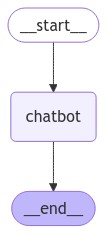

In [7]:
from IPython.display import display, Image, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# test the graph
prompt = "What's the largest mammal in the world?"
response = graph.invoke({"messages": ("user", prompt)})

In [9]:
response

{'messages': [HumanMessage(content="What's the largest mammal in the world?", id='afb10ecf-74f0-437e-a75b-2b15bca6d9ee'),
  AIMessage(content='The largest mammal in the world is the blue whale (*Balaenoptera musculus*). Adult blue whales can reach lengths of up to 100 feet (30 meters) and can weigh as much as 200 tons or more. They are known for their immense size and are found in oceans around the globe.', response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 16, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-4bbd1257-2dd2-4e83-bd02-4ed6e7b76dfd-0')]}

In [10]:
# display in markdown
display(Markdown(response["messages"][-1].content))

The largest mammal in the world is the blue whale (*Balaenoptera musculus*). Adult blue whales can reach lengths of up to 100 feet (30 meters) and can weigh as much as 200 tons or more. They are known for their immense size and are found in oceans around the globe.

## Add Tools to the graph.

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import requests

# define a tavily search tool
tv_search = TavilySearchResults(
    max_results=3,
    search_depth='advanced',
    max_tokens=1e5
)

@tool
def search_web(query: str) -> list:
    """Search the web for query"""
    return tv_search.invoke(query)

@tool
def get_weather(query) -> list:
    """Seach weather API to get current weather"""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={os.getenv('WHEATER_API_KEY')}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather data not found" 

### Create Grahp with tools

In [12]:
class State(TypedDict):
    """
    messages are a list, and add_messages is a function that adds a message to the list instead of
    overwrite them.
    """
    messages: Annotated[list, add_messages]

# define base graph
graph_builder = StateGraph(State)
# define llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
# define tools to use
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

# now define chatbot
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
# add node to the graph
graph_builder.add_node("chatbot", chatbot)

In [13]:
import json
from langchain_core.messages import ToolMessage

# need to add tools to new nodes, in this way tools will be called
class BasicToolNode:
    """Node that runs the tools requested in the las AIMessage."""
    def __init__(self, tools:list):
        self.tools_by_name = {tool.name: tool for tool in tools}
    def __call__(self, inputs:dict):
        if messages := inputs.get("messages", []):
            # get most recent message
            message = messages[-1]
        else:
            raise ValueError("No messages in inputs")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"],
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )
        
        return {"messages": outputs}

# add node to the graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [14]:
from typing import Literal

# now need to define the conditional edges, which are going to be
# the ways to go from one node to another, depending on the tool calling
# for this a function called route_tools is going to be defined that checks for
# the tool calling.

def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    Route edge if tools are called in the last meesage.
    Otherwise, end the graph.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages in state to tool_edge: {state}")

    # check if messages has the "tool_call" attribute
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # if has no tool calling then just end the graph
    return "__end__"


In [15]:
# this conditional rote defines the main agent loop
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)

In [16]:
# any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# set entry point
graph_builder.set_entry_point("chatbot")
# now compile agent
graph = graph_builder.compile()

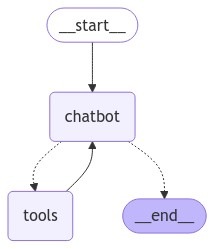

In [17]:
# check the current flow
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# test new agent
prompt = "What's the largest mammal in the world?"
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response["messages"][-1].content))

The largest mammal in the world is the blue whale (*Balaenoptera musculus*). Blue whales can reach lengths of up to 100 feet (30 meters) and can weigh as much as 200 tons or more. They are known for their immense size and are found in oceans around the globe.

In [ ]:
# test new agent
prompt = "What's Langraph?"
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response["messages"][-1].content))

Langraph is a library within the LangChain ecosystem designed to simplify the development of complex, multi-agent large language model (LLM) applications. It provides a controllable cognitive architecture that supports diverse and complex tasks, featuring stateful, multi-agent, and streaming capabilities. 

Key features of Langraph include:

1. **Hierarchical Retrieval and Generation**: It employs a hierarchical approach to querying and generating responses, which allows for handling complex multi-turn conversations effectively.

2. **Enhanced Retrieval Techniques**: Langraph utilizes techniques like Hypothetical Question Generation (HyDE) to improve information retrieval.

3. **Scalability and Flexibility**: It offers developers the tools and infrastructure needed to build scalable and flexible AI applications.

Overall, Langraph is aimed at creating advanced AI systems that require both information retrieval and language generation capabilities.

In [ ]:
# test new agent
prompt = "What is the weather in NYC?"
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response["messages"][-1].content))

The current weather in New York City is as follows:

- **Temperature**: 1.7°C (35.1°F)
- **Condition**: Clear
- **Wind**: 6.5 mph (10.4 kph) from the Northwest
- **Humidity**: 35%
- **Feels Like**: -1.4°C (29.5°F)
- **Visibility**: 16 km (9 miles)

No precipitation is expected, and the pressure is 1006 mb.

## Build agent with LangGraph built-ins: Recommended Flow 

In [23]:
from typing import Annotated

from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [24]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start graph building
graph_builder = StateGraph(State)
# add tools  and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

# add llm to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)

# add tools node
tool_node = ToolNode(tools=tools) # no need to define `BasicToolNode`
graph_builder.add_node("tools", tool_node)


# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # no need to define manually `route_tools`
    {"tools": "tools", "__end__": "__end__"}
)
# add tools to chatbot
graph_builder.add_edge("tools", "chatbot")
# define entry point
graph_builder.set_entry_point("chatbot")
# compile
graph = graph_builder.compile()


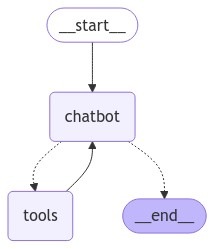

In [25]:
# check graph again
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# test new agent
prompt = "What's Langraph?"
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response["messages"][-1].content))

Langraph is a library within the LangChain ecosystem designed to simplify the development of complex, multi-agent large language model (LLM) applications. It provides a controllable cognitive architecture that supports diverse and complex tasks, featuring stateful, multi-agent, and streaming capabilities. 

Key features of Langraph include:

1. **Hierarchical Retrieval and Generation**: It employs a hierarchical approach to querying and generating responses, which allows for handling complex multi-turn conversations effectively.

2. **Enhanced Retrieval Techniques**: Langraph enhances information retrieval using methods like Hypothetical Question Generation (HyDE), which helps in generating relevant and context-aware responses.

3. **Scalability and Flexibility**: It offers developers the tools and infrastructure needed to build scalable and flexible AI applications, making it suitable for next-generation AI systems.

For more detailed information, you can check out the following resources:
- [Comprehensive Guide to Langraph](https://medium.com/@jagadeesan.ganesh/a-comprehensive-guide-to-langraph-step-by-step-with-examples-56ab31a987ee)
- [LangGraph Tutorial on DataCamp](https://www.datacamp.com/tutorial/langgraph-tutorial)
- [LangGraph Official Page](https://www.langchain.com/langgraph)

In [ ]:
# EOF